<a href="https://colab.research.google.com/github/GeunheeHan/2020-2-AI/blob/main/20173842_%ED%95%9C%EA%B7%BC%ED%9D%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. 회귀 문제 : 자동차 연비 예측

● 문제 개요와 목적
- 자동차 연비의 연속된 출력 값을 예측하는 것이 목적

- MPG 데이터셋 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비 예측

- 실린더 수, 배기량, 마력, 공차 중량 같은속성이 포함

In [38]:
# 라이브러리 가져오기
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [40]:
# Auto MPG 데이터셋 다운로드
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [41]:
# pandas 를 이용하여 데이터를 읽게함
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [42]:
# 일부 데이터가 누락되어 있는 것을 확인 할 수 있음
dataset.isna().sum()


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [43]:
# 누락된 행을 드랍
dataset = dataset.dropna()


In [44]:
# 원-핫 인코딩으로 변환
origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [45]:
# 데이터셋을 훈련 세트와 테스트 세트로 분할
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)


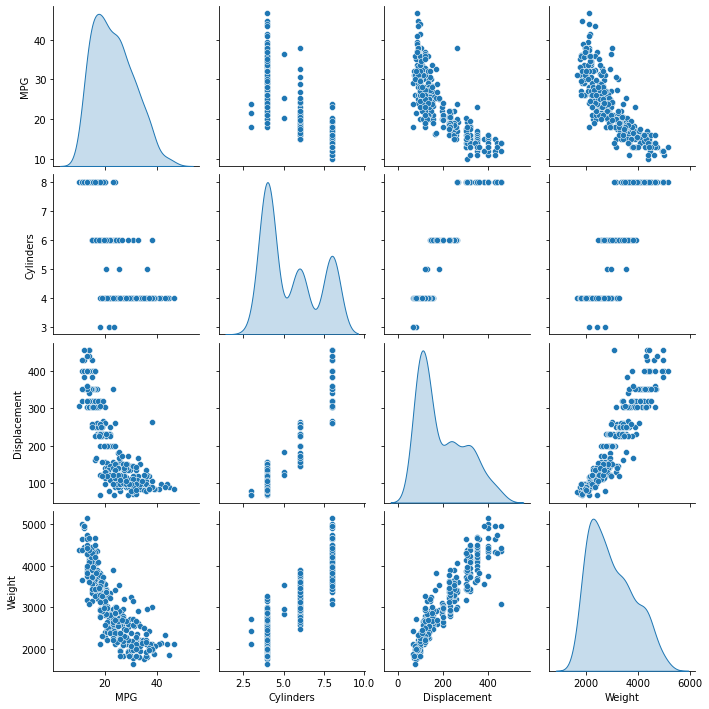

In [46]:
# 훈련 세트에서 일부 열을 선택하여 산점도 행렬 생성
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


In [47]:
# 전반적인 통계 확인
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [48]:
# 해당 특성에서 타깃 값 또는 레이블(훈련대상)을 분리
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')


In [49]:
# 데이터를 정규화
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


In [50]:
# Sequential 모델 생성 및 옵티마이저 설정
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

# 모델 확인
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [51]:
# 훈련세트에서 20개의 샘플을 배치로 만들어 예측
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.1478067 ],
       [-0.14471087],
       [-0.2684725 ],
       [ 0.09681803],
       [-0.00126728],
       [-0.20836666],
       [-0.02568239],
       [ 0.282773  ],
       [-0.30190325],
       [-0.19439289]], dtype=float32)

In [52]:
# 모델 훈련, 훈련과 검증 정확도는 history 객체에 기록
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

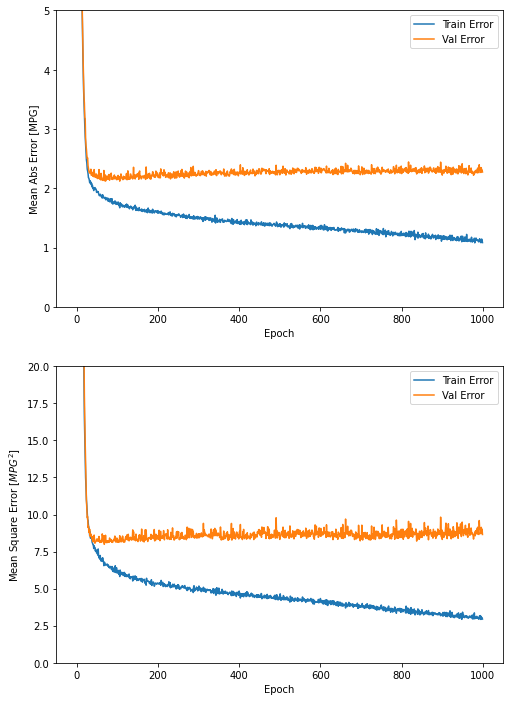

In [53]:
# 검증 과정이 기록된 history 객체 시각화
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)
# 100번째 에포크 이후 모델이 향상되지 않는것을 확인



.....................................................

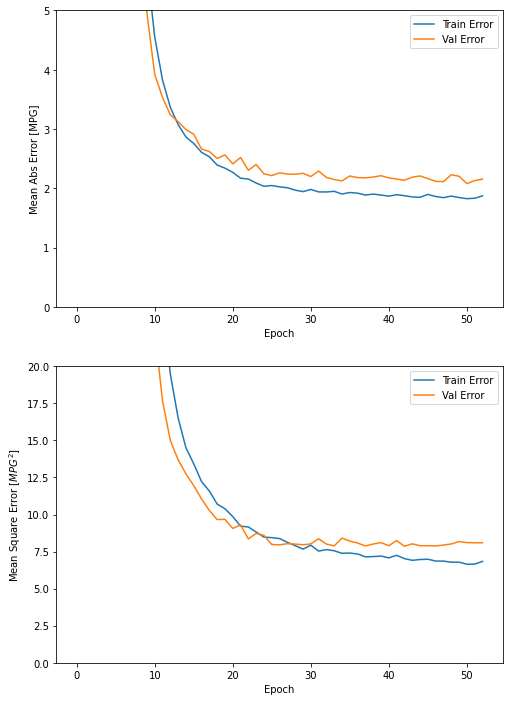

In [54]:
# 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 하게 model.fit 메소드 수정
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()]) #EarlyStopping

plot_history(history)


In [55]:
# 테스트 세트의 평균 절대 오차 출력
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))


3/3 - 0s - loss: 5.9971 - mae: 1.8908 - mse: 5.9971
테스트 세트의 평균 절대 오차:  1.89 MPG


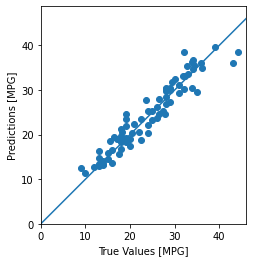

In [56]:
# 테스트 세트에 있는 샘플을 활용해 MPG 값을 예측
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


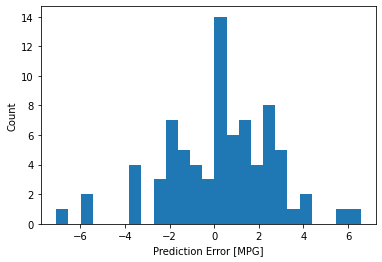

In [57]:
# 훈련 샘플의 수가 작기 때문에 가우시안 분포 X
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")


### 2. 분류 문제 : Iris 붓꽃 분류

● 문제 개요와 목적
- Iris(붓꽃) 은 외떡잎식물 백합목 붓꽃과의 여러해살이풀이며 크게 꽃받침(Sepal)과 꽃잎(Petal)의 길이와 폭에 따라 Setosa, Vericolor, Virginica 로 나뉜다.

- 해당 분류 문제는 붓꽃의 종류를 판별하기 위한 목적으로 쓰이는 분류이다.

- Iris 데이터 세트를 사용하여 모델을 훈련할 것이며 꽃받침의 길이, 넓이 / 꽃잎의 길이, 넓이의 특성을 식별함

- 120개의 붓꽃 데이터를 가져와 훈련시킬 예정

In [2]:
# 라이브러리 가져오기
import os
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
# 분류에 필요한 훈련, 테스트 데이터셋 가져오기
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)


8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [4]:
# 특성과 레이블 참조
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("특성: {}".format(feature_names))
print("레이블: {}".format(label_name))

특성: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
레이블: species


In [5]:
#레이블의 이름들을 매핑
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']


In [6]:
# 데이터셋 생성 (CSV 함인)
batch_size = 64 #배치 사이즈 64개로 설정

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)


In [7]:
#feature 과 label 쌍으로 구성된 데이터셋 반환
features, labels = next(iter(train_dataset))


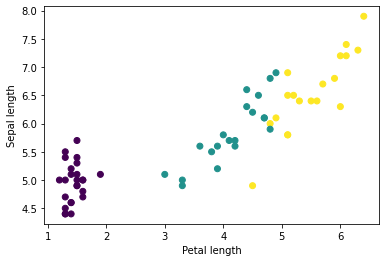

In [8]:
#군집 데이터를 그래프로 확인
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show() 

In [9]:
def pack_features_vector(features, labels):
  features = tf.stack(list(features.values()), axis=1) # 단일 배열로 다시 구성하는 함수를 생성
  return features, labels

In [10]:
#(features, label) 쌍의 특성을 훈련 데이터 세트에 쌓기 위하여 메서드 사용
train_dataset = train_dataset.map(pack_features_vector)


In [11]:
# 첫 10개행의 샘플 참조
features, labels = next(iter(train_dataset))

print(features[:10])


tf.Tensor(
[[6.6 3.  4.4 1.4]
 [4.4 3.2 1.3 0.2]
 [6.1 2.6 5.6 1.4]
 [5.5 2.4 3.8 1.1]
 [5.7 3.  4.2 1.2]
 [6.1 2.8 4.  1.3]
 [5.7 2.9 4.2 1.3]
 [7.3 2.9 6.3 1.8]
 [6.8 3.2 5.9 2.3]
 [7.4 2.8 6.1 1.9]], shape=(10, 4), dtype=float32)


In [12]:
# 모델 생성 ( 10개의 노드를 가지는 2개의 Dense 층과 3개의 예측 노드를 가지는 출력 층)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 처음 10개의 예측 결과 모델 확인
predictions = model(features)
predictions[:10]


<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[-1.8860636, -1.7104977, -1.834275 ],
       [-1.3480117, -1.510986 , -1.5460328],
       [-2.0641234, -1.4467868, -1.8132935],
       [-1.672412 , -1.4057225, -1.5956438],
       [-1.6725854, -1.5842121, -1.6490636],
       [-1.7178025, -1.5901755, -1.6822987],
       [-1.6088885, -1.5323758, -1.5713565],
       [-2.304913 , -1.6568253, -2.0193067],
       [-1.5873177, -1.5493755, -1.4157848],
       [-2.2276316, -1.6326225, -1.9499785]], dtype=float32)>

In [14]:
tf.nn.softmax(predictions[:10]) # 소프트맥스 함수를 이용하여 로짓을 각 클래스에 대한 확률로 변환

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[0.30815944, 0.36730152, 0.32453904],
       [0.37453663, 0.31821123, 0.30725208],
       [0.24159989, 0.4479222 , 0.31047794],
       [0.29538372, 0.38566333, 0.31895292],
       [0.32090402, 0.3505542 , 0.32854173],
       [0.31523162, 0.35814384, 0.32662463],
       [0.320743  , 0.34624717, 0.33300987],
       [0.23571286, 0.450655  , 0.31363213],
       [0.31000116, 0.32198927, 0.36800957],
       [0.24195057, 0.43866786, 0.31938156]], dtype=float32)>

In [15]:
# 해당 함수를 이용하여 모델의 손실 계산
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [16]:
# 손실값을 계산하는 함수
def loss(model, x, y):
  y_ = model(x)

  return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels)
print("손실 테스트: {}".format(l))


손실 테스트: 1.0225661993026733


In [17]:
# 그레디언트를 계산하기 위한 코드
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)


In [18]:
# 옵티마이저 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [19]:
# 최적화 단계를 계산
loss_value, grads = grad(model, features, labels)

print("단계: {}, 초기 손실: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("단계: {},      손실: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels).numpy()))


단계: 0, 초기 손실: 1.0225661993026733
단계: 1,      손실: 0.9846823215484619


In [22]:
# 도식화를 위해 결과를 저장
train_loss_results = []
train_accuracy_results = []

num_epochs = 251 #정확도가 가장 높게나오는 251번 시도

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # 훈련 루프
  for x, y in train_dataset:
    # 모델을 최적화
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # 진행 상황을 추적
    epoch_loss_avg(loss_value)  # 현재 배치 손실을 추가
    # 예측된 레이블과 실제 레이블 비교
    epoch_accuracy(y, model(x))

  # epoch 종료
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("epoch {:03d}: loss: {:.3f}, accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))


epoch 000: loss: 0.045, accuracy: 99.167%
epoch 050: loss: 0.046, accuracy: 99.167%
epoch 100: loss: 0.044, accuracy: 98.333%
epoch 150: loss: 0.040, accuracy: 98.333%
epoch 200: loss: 0.040, accuracy: 99.167%
epoch 250: loss: 0.035, accuracy: 99.167%
epoch 300: loss: 0.034, accuracy: 99.167%


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54984 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54984 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47144 missing from current font.
  font.set_te

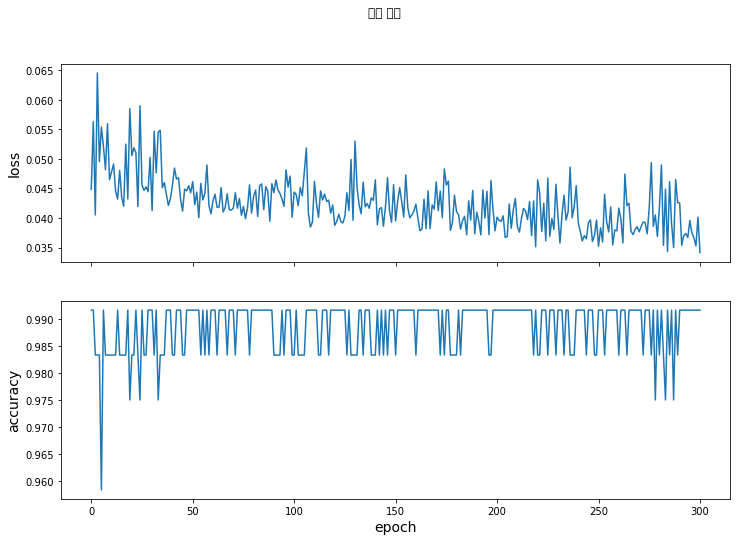

In [23]:
# 정확도와 손실을 시각화한 함수 그래프 (시간경과에 따라)
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('훈련 지표')

axes[0].set_ylabel("loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("accuracy", fontsize=14)
axes[1].set_xlabel("epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()


In [24]:
#테스트 데이터 세트 설정
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)


In [25]:
#테스트 데이터 세트 활용 모델 평가
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("테스트 데이터 세트 활용 모델 정확도: {:.3%}".format(test_accuracy.result()))


테스트 데이터 세트 활용 모델 정확도: 96.667%


In [26]:
# 일정한 몇개의 훈련된 모델을 통한 예측 결과
predict_dataset = tf.convert_to_tensor([
    [8.4, 6.2, 2.5, 0.3,],
    [4.2, 3.0, 7.0, 0.5,],
    [6.2, 1.9, 2.4, 1.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("sample {} predict: {} ({:4.1f}%)".format(i, name, 100*p))


sample 0 predict: Iris setosa (100.0%)
sample 1 predict: Iris virginica (79.0%)
sample 2 predict: Iris versicolor (99.9%)


### 3. CNN 문제 : CIFAR-10 분류

● 문제 개요와 목적

In [27]:
from keras import backend
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt

In [28]:
#훈련, 테스트 데이터 로드
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [29]:
#데이터 정규화
train_x = train_x.astype('float32') / 255
test_x = test_x.astype('float32') / 255
train_y = np_utils.to_categorical(train_y, 10)
test_y = np_utils.to_categorical(test_y, 10)

train_x.shape

(50000, 32, 32, 3)

In [30]:
# 컨볼루션 신경망 모델을 포함한 네트워크 모델 생성
def build(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding = 'same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

model = build(input_shape=(32,32,3))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [31]:
history = model.fit(train_x, train_y, batch_size=256, epochs=10, validation_split=0.2, verbose=1)
score = model.evaluate(test_x, test_y, batch_size = 256, verbose = 1)

Epoch 1/10
157/157 [==============================] - 50s 316ms/step - loss: 1.7286 - accuracy: 0.3926 - val_loss: 1.4425 - val_accuracy: 0.4877
Epoch 2/10
157/157 [==============================] - 52s 329ms/step - loss: 1.3253 - accuracy: 0.5319 - val_loss: 1.3017 - val_accuracy: 0.5378
Epoch 3/10
157/157 [==============================] - 50s 318ms/step - loss: 1.1852 - accuracy: 0.5843 - val_loss: 1.1902 - val_accuracy: 0.5899
Epoch 4/10
157/157 [==============================] - 50s 320ms/step - loss: 1.0895 - accuracy: 0.6200 - val_loss: 1.2073 - val_accuracy: 0.5777
Epoch 5/10
157/157 [==============================] - 50s 318ms/step - loss: 1.0236 - accuracy: 0.6445 - val_loss: 1.1314 - val_accuracy: 0.6083
Epoch 6/10
157/157 [==============================] - 50s 318ms/step - loss: 0.9609 - accuracy: 0.6643 - val_loss: 1.1165 - val_accuracy: 0.6167
Epoch 7/10
157/157 [==============================] - 54s 341ms/step - loss: 0.8972 - accuracy: 0.6896 - val_loss: 1.0891 - val_ac

정확도 : 64.63000178337097 %


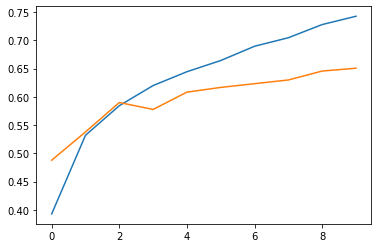

In [32]:
# 정확도 표시
print("정확도 : " + str( score[1] * 100 ) + " %" )

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])



In [33]:
# 드랍아웃 등을 적용하여 계층을 쌓아 정확도 상승 시도
def build(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding = 'same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Dropout(0.25)) # 드랍아웃
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25)) # 드랍아웃
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5)) # 드랍아웃
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

model_dr = build(input_shape=(32,32,3))
model_dr.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history_dr = model_dr.fit(train_x, train_y, batch_size=256, epochs=10, validation_split=0.2, verbose=1)
score_dr = model_dr.evaluate(test_x, test_y, batch_size = 256, verbose = 1)
print("정확도 : " + str( score_dr[1] * 100 ) + " %" )

Epoch 1/10
157/157 [==============================] - 90s 575ms/step - loss: 1.7498 - accuracy: 0.3705 - val_loss: 1.5154 - val_accuracy: 0.4904
Epoch 2/10
157/157 [==============================] - 89s 570ms/step - loss: 1.3587 - accuracy: 0.5146 - val_loss: 1.3228 - val_accuracy: 0.5762
Epoch 3/10
157/157 [==============================] - 91s 577ms/step - loss: 1.2128 - accuracy: 0.5691 - val_loss: 1.2662 - val_accuracy: 0.6049
Epoch 4/10
157/157 [==============================] - 89s 569ms/step - loss: 1.1141 - accuracy: 0.6082 - val_loss: 1.1458 - val_accuracy: 0.6324
Epoch 5/10
157/157 [==============================] - 90s 571ms/step - loss: 1.0408 - accuracy: 0.6316 - val_loss: 1.0806 - val_accuracy: 0.6492
Epoch 6/10
157/157 [==============================] - 90s 572ms/step - loss: 0.9696 - accuracy: 0.6590 - val_loss: 1.0094 - val_accuracy: 0.6743
Epoch 7/10
157/157 [==============================] - 91s 577ms/step - loss: 0.9186 - accuracy: 0.6765 - val_loss: 1.0043 - val_ac

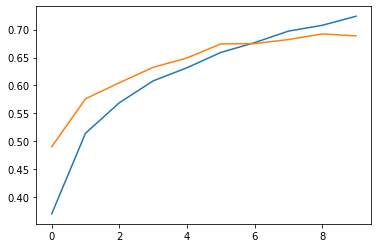

In [35]:
# 상승된 정확도 값 함수의 그래프
plt.plot(history_dr.history['accuracy'])
plt.plot(history_dr.history['val_accuracy'])

#이로 말미암아 드랍아웃과 epoch의 개수를 조정해준다면 좀더 나은 결과가 나올 수 있을거라 예상됨